In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
pd.set_option('display.max_columns', 60)
myData=pd.read_csv('imputedData.csv')
myData.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
#One hot encoding of categorical variables

#Create list with features to be dummified cols.
nonum_feats_names = ['Month','OperatingSystems','Browser','Region','VisitorType','Weekend']


dataModel = pd.concat([myData[['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']],
                       pd.get_dummies(myData[nonum_feats_names].astype('category')),myData['Revenue']],axis=1)
                      
dataModel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 57 columns):
Administrative                   12330 non-null int64
Administrative_Duration          12330 non-null float64
Informational                    12330 non-null int64
Informational_Duration           12330 non-null float64
ProductRelated                   12330 non-null int64
ProductRelated_Duration          12330 non-null float64
BounceRates                      12330 non-null float64
ExitRates                        12330 non-null float64
PageValues                       12330 non-null float64
TrafficType                      12330 non-null int64
SpecialDay                       12330 non-null float64
Month_Aug                        12330 non-null uint8
Month_Dec                        12330 non-null uint8
Month_Feb                        12330 non-null uint8
Month_Jul                        12330 non-null uint8
Month_June                       12330 non-null uint8
Month_Mar    

In [4]:
#Label Encoding of revenue

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
myData['Revenue'] = le.fit_transform(myData['Revenue'])
myData['Revenue'].value_counts()

myData['Revenue'].head()

# getting dependent and independent variables

x = dataModel
# removing the target column revenue from x
x = x.drop(['Revenue'], axis = 1)

y = myData['Revenue']

# checking the shapes
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (12330, 56)
Shape of y: (12330,)


In [5]:
# splitting the data

from sklearn.model_selection import train_test_split

x_baseTrain, x_baseTest, y_baseTrain, y_baseTest = train_test_split(x, y, test_size = 0.3, random_state = 42)

# checking the shapes

print("Shape of x_train :", x_baseTrain.shape)
print("Shape of y_train :", y_baseTrain.shape)
print("Shape of x_test :", x_baseTest.shape)
print("Shape of y_test :", y_baseTest.shape)

Shape of x_train : (8631, 56)
Shape of y_train : (8631,)
Shape of x_test : (3699, 56)
Shape of y_test : (3699,)


In [6]:
#SCALING WITH STANDARD Z SCORE SCALER
#Scaling the data first fitting it and transforming the training set
#to later apply the fit to transform the test set.
from sklearn.preprocessing import StandardScaler

num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 
                              'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
                               'TrafficType','SpecialDay']

#Instantiate Satandard Scaler
scaler = StandardScaler()
#Fit transform the numerical features in the training dataset to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(x_baseTrain[num_cols_names]), 
                                     columns=num_cols_names, index= x_baseTrain.index)
#Integrate scaled values to the training set
for col in num_cols_names:
    x_baseTrain[col] = scaled_numfeats_train[col]
    
    
#Transform the numerical features inthe training dataset to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(x_baseTest[num_cols_names]),
                                    columns=num_cols_names, index= x_baseTest.index)
#Integrate scaled values to the test set
for col in num_cols_names:
    x_baseTest[col] = scaled_numfeats_test[col]

C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\neera\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [7]:
# here I will do the model fitting and feature selection
# altogether in one line of code

# first I specify the Random Forest instance, indicating
# the number of trees

# Then I use the selectFromModel object from sklearn
# to automatically select the features

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel_ = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel_.fit(x_baseTrain, y_baseTrain)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [8]:
# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [9]:
# let's make a list and count the selected features
selected_feat = x_baseTrain.columns[(sel_.get_support())]
len(selected_feat)
selected_feat

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'TrafficType', 'Month_Nov'],
      dtype='object')

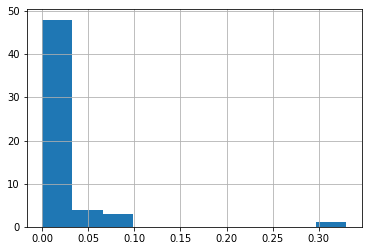

In [10]:
# and now let's plot the distribution of importances

pd.Series(sel_.estimator_.feature_importances_.ravel()).hist()

In [11]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((x_baseTrain.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(sel_.estimator_.feature_importances_ > sel_.estimator_.feature_importances_.mean())))

total features: 56
selected features: 11
features with coefficients greater than the mean coefficient: 11


# Top 11 features based on RF Feature Importance 

Administrative
Administrative_Duration
Informational
Informational_Duration
ProductRelated
ProductRelated_Duration
BounceRates
ExitRates
PageValues
TrafficType
Month_Nov

Now I will run the same feature selection on corr fixed data

In [12]:
x_baseTrain.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                 axis=1, inplace=True)
x_baseTest.drop(labels=['Browser_1','BounceRates','ProductRelated','VisitorType_Returning_Visitor'], 
                axis=1, inplace=True)

x_baseTrain.shape, x_baseTest.shape

C:\Users\neera\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((8631, 52), (3699, 52))

In [13]:
# here I will do the model fitting and feature selection
# altogether in one line of code

# first I specify the Random Forest instance, indicating
# the number of trees

# Then I use the selectFromModel object from sklearn
# to automatically select the features

# SelectFrom model will select those features which importance
# is greater than the mean importance of all the features
# by default, but you can alter this threshold if you want to

sel1_ = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel1_.fit(x_baseTrain, y_baseTrain)

# this command let's me visualise those features that were selected.

# sklearn will select those features which importance values
# are greater than the mean of all the coefficients.

sel1_.get_support()

# let's make a list and count the selected features
selected_featCorr = x_baseTrain.columns[(sel1_.get_support())]
len(selected_featCorr)
selected_featCorr

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated_Duration', 'ExitRates',
       'PageValues', 'TrafficType', 'Month_Nov'],
      dtype='object')

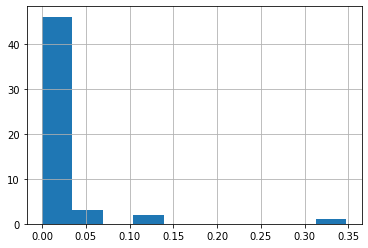

In [14]:
# and now let's plot the distribution of importances

pd.Series(sel1_.estimator_.feature_importances_.ravel()).hist()

In [15]:
# and now, let's compare the  amount of selected features
# with the amount of features which importance is above the
# mean importance, to make sure we understand the output of
# sklearn

print('total features: {}'.format((x_baseTrain.shape[1])))
print('selected features: {}'.format(len(selected_featCorr)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(sel1_.estimator_.feature_importances_ > sel1_.estimator_.feature_importances_.mean())))

total features: 52
selected features: 9
features with coefficients greater than the mean coefficient: 9


# Top 9 features on corr fixed data based on RF Feature Importance

Administrative
Administrative_Duration
Informational
Informational_Duration
ProductRelated_Duration
ExitRates
PageValues
TrafficType
Month_Nov

Next I will perform Random Forest Recursive feature selection on the corr fixed data

In [22]:
# here I will do the model fitting and feature selection
# altogether in one line of code

# first I specify the Random Forest instance, indicating
# the number of trees

# Then I use the selectFromModel object from sklearn
# to automatically select the features

# RFE will remove one feature at each iteration, the
# least  important.
# then it will build another random forest and repeat
# till a criteria is met.

# in sklearn the criteria to stop is an arbitrary number
# of features to select, that you need to decide before hand
# not the best solution, but a solution
from sklearn.feature_selection import RFE
sel2_ = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=25)
sel2_.fit(x_baseTrain, y_baseTrain)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=25, step=1, verbose=0)

In [23]:
# this command let's me visualise those features that were selected.
sel2_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True, False, False, False,  True,  True,  True, False,
       False,  True,  True,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False,  True,
       False, False, False,  True, False,  True,  True])

In [24]:
# let's add the variable names and order it for clearer visualisation
selected_featCorrRFE = x_baseTrain.columns[(sel2_.get_support())]
len(selected_featCorrRFE)
# let's display the list of features
selected_featCorrRFE

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated_Duration', 'ExitRates',
       'PageValues', 'TrafficType', 'Month_Dec', 'Month_Mar', 'Month_May',
       'Month_Nov', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'Browser_2', 'Browser_4', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_6', 'VisitorType_New_Visitor',
       'Weekend_False', 'Weekend_True'],
      dtype='object')

# Top 25 features based on Random forest RFE

Administrative
Administrative_Duration
Informational
Informational_Duration
ProductRelated_Duration
ExitRates
PageValues
TrafficType
Month_Dec
Month_Mar
Month_May
Month_Nov
OperatingSystems_1
OperatingSystems_2
OperatingSystems_3
Browser_2
Browser_4
Region_1
Region_2
Region_3
Region_4
Region_6
VisitorType_New_Visitor
Weekend_False
Weekend_True

WE can compare RFE style of feature selecture vs  traditional style of feature selection